## Using the global index to deal with non-stationarity in the data

In this section we will adjust the returns using the global msci index and see how well the models we saw in the last section perform on this new data. Let us take a look at the index data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os

In [2]:
index=pd.read_csv("index/INDEX.csv", skiprows=8)
index = index.drop(["NAME", "TICKER", "SECTOR", "COUNTRY"], axis=1) # drop the non-numeric columns
index.head()

,9/20/2020,8/31/2020,7/31/2020,6/30/2020,5/31/2020,4/30/2020,3/31/2020,2/29/2020,1/31/2020,12/31/2019,...,10/31/2001,9/30/2001,8/31/2001,7/31/2001,6/30/2001,5/31/2001,4/30/2001,3/31/2001,2/28/2001,1/31/2001
0,-0.0422,0.061207,0.052886,0.031953,0.04349,0.107128,-0.135004,-0.080771,-0.011044,0.035213,...,0.021103,-0.091604,-0.046299,-0.015965,-0.030922,-0.011752,0.07241,-0.067679,-0.08433,0.02514


More information about the global msci index can be found on [their website](https://www.msci.com/developed-markets). We use this data to adjust the returns in ```TotalReturn_BaseCCY.csv``` using the following geometric return formula

$$
    r_i = \frac{1 + r_i}{1 + x_i} - 1.
$$

Where $r_i$ is the return in some month $i$, and $x_i$ is the global msci index in month $i$. Let us adjust the returns using the formula above.

In [3]:
from sklearn.preprocessing import MinMaxScaler

# load the return data into a dataframe
returns = pd.read_csv("Data/TotalReturn_BaseCCY.csv")

# the global msci data is missing values for the year 2000 so we remove those years
returns = returns[list(returns.columns[:-12])] 

# change the columns in the index data to be the same as the columns in the return data
index.columns = returns.columns[4:]

# calculate the geometric return
returns[returns.columns[4:]] += 1
returns[returns.columns[4:]] = returns[returns.columns[4:]].divide(1 + index.iloc[0], axis=1)
returns[returns.columns[4:]] -= 1

# Remove the years we are not interested in
for col in returns.columns[4:]:
    year = col[:4]
    if year not in ['2004', '2007', '2010', '2013', '2016', '2019']:
        returns.drop(col, inplace=True, axis=1)
        
returns.head()

,NAME,TICKER,SECTOR,COUNTRY,2019-12-31,2019-11-30,2019-10-31,2019-09-30,2019-08-31,2019-07-31,...,2004-10-31,2004-09-30,2004-08-31,2004-07-31,2004-06-30,2004-05-31,2004-04-30,2004-03-31,2004-02-29,2004-01-31
0,Aberdeen Asset Management PLC,1,Financials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.062257,0.106229,-0.003862,-0.021665,0.026977,-0.107461,-0.068498,0.017212,0.134124,-0.023603
1,Abbey National Plc,2,Financials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.115492,-0.077185,0.051913,0.144367,0.109332,0.017423,-0.017317,-0.031579,-0.162617,0.092197
2,Chubb Plc,3,Industrials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Kidde Plc,4,Consumer Discretionary,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.344558,0.041638,-0.027044,0.031550,0.018952,0.041955,0.096762,0.071833,-0.041366,-0.065798
4,Amec Foster Wheeler plc,5,Industrials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.012368,-0.016117,0.147616,0.033039,-0.012902,-0.066767,-0.036570,0.095799,0.034421,0.049920


Now that we have adjusted the returns we need to preprocess the returns in the same way as we did in the previous notebook. To make this easier we simply copy a few functions from the previous notebook.

In [4]:
def stackData(x):
    # column names of new dataframe
    columns = [
    'NAME',
    'TICKER',
    'SECTOR',
    'COUNTRY',
    'DEC', 'NOV', 'OCT', 'SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR', 'MAR', 'FEB', 'JAN',
    'YEAR']
    
    x_stacked = pd.DataFrame(columns=columns)
    
    subframes = []
    i = 4
    while i < x.shape[1]:
        # extract NAME, TICKER, SECTOR, COUNTRY, and 12 months of returns form x
        subframe = x[list(x.columns[0:4]) + list(x.columns[i:i+12])].copy()

        subframe['YEAR'] = int(x.columns[i][:4])
        subframe.columns = x_stacked.columns

        # append the subframe to the end of x_stacked
        x_stacked = x_stacked.append(subframe)
        i += 12

    # drop any rows that have a missing value in it
    x_stacked = x_stacked.dropna(axis=0)

    # reset the index to go 0, 1, 2, 3, ...
    x_stacked.reset_index(drop=True, inplace=True)
    return x_stacked

def boundStackedData(x):
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    for month in months:
        upperlim = x[month].quantile(0.95) # 95th percentile
        lowerlim = x[month].quantile(0.05) # 5th percentile
        x.loc[(x[month] > upperlim), month] = upperlim 
        x.loc[(x[month] < lowerlim), month] = lowerlim 
    return x

def calculateGeometricMean(x):
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    x["AVERAGE RETURN"] = (x[months] + 1).product(axis=1) - 1

    # drop the monthly returns from the dataframe
    x = x.drop(months, axis=1)
    return x

Now we can preprocess the returns.

In [5]:
returns = stackData(returns)
returns = boundStackedData(returns)
returns = calculateGeometricMean(returns)

Let us save the adjusted returns and create our training and test set.

In [6]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('X.csv')

# replace the average returns in X.csv with the adjusted average returns
df['AVERAGE RETURN'] = returns["AVERAGE RETURN"]
df.to_csv("X_index_adjusted.csv", index=False)

X = df.copy()
X = X.drop([
    "NAME",
    "TICKER",
    "SECTOR",
    "COUNTRY",
    "YEAR",
    "AVERAGE RETURN"],
axis=1)

y = df['AVERAGE RETURN']

# split X and y into a training and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30)

Let us see how OLS performs on this new data.

In [7]:
from statsmodels.api import OLS

ols_model = OLS(y_train,X_train)
res = ols_model.fit()

y_hat = res.predict(X_train)
print("Training error:", mean_squared_error(y_hat, y_train))

y_hat = res.predict(X_test)
print("Test error:", mean_squared_error(y_hat, y_test))

Training error: 0.10152695813062454
Test error: 0.09967348417571918


Now let us see how a random forest performs on the data.

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(criterion = 'mse')
rf.fit(X_train, y_train)
train_mse = mean_squared_error(y_train, rf.predict(X_train))
test_mse = mean_squared_error(y_test, rf.predict(X_test))
print("training error: ", train_mse)
print("Test error: ", test_mse)

training error:  0.013615033347957843
Test error:  0.09170829984108567


Let us look at the feature importance for the random forest.

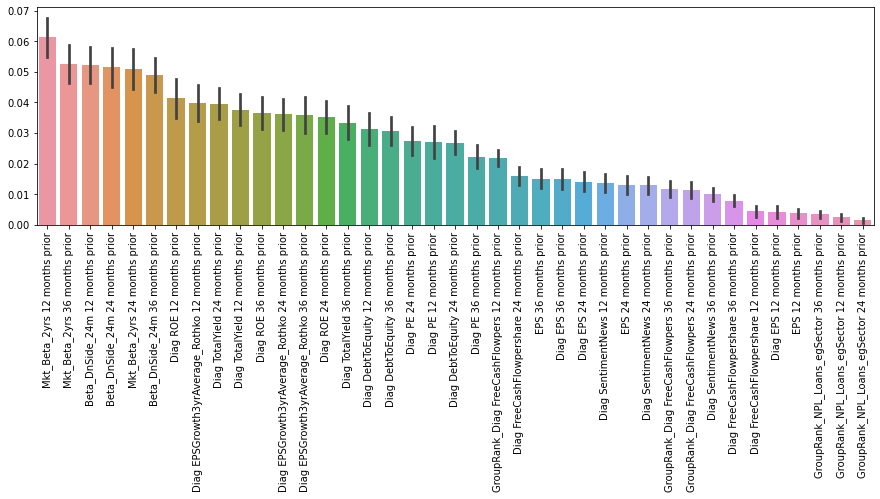

In [9]:
trees = rf.estimators_
feature_importances = pd.DataFrame(index = X.columns)

for i in range(len(trees)):
    col_name = "tree_" + str(i)
    feature_importances[col_name] = trees[i].feature_importances_

# now we find the mean feature importance
tree_names = feature_importances.columns
feature_importances['mean_feature_importance'] = feature_importances[tree_names].mean(axis=1)
feature_importances = feature_importances.sort_values(by=['mean_feature_importance'], ascending=False)
feature_importances = feature_importances.drop('mean_feature_importance', axis=1)

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.barplot(
    data=feature_importances.T, 
    ax=ax,
    ci="sd" # include standard deviation error bars
)
# rotate the x-axis labels by 90 degrees
ax.set_xticklabels(rotation=90, labels=feature_importances.index);

# Explainability 

A huge issue in artificial intelligence at the moment is explainability. A lot of machine learning algorithms are classified as black box models. A black box model is a defined as a model that produces some output $y$ from some input $x$ without the user having knowledge of the internal workings of the model. So, why should we trust a black box model if we don't know exactly why it behaves the way it does? This is a difficult question and in this section we will see two different approaches we can take to explain a black box model to make it easier to make sense of its behaviour.

## Lime

Lime is the first package we will look at that attempts to address the explainability problem. Let us suppose we have a model that produces some output $\hat{y}$ for some input $x$. Lime attempts to explain the output $\hat{y}$ by peturbing the input $x$ slightly and attempts to predict how the model will respond to this perturbation. So, lime attempts to understand why the model behaves the way it does locally around $x$. Let us use lime to explain the random forest we trained.  

In [10]:
import lime
import lime.lime_tabular

prediction:  0.13880450848443934
True value:  0.388922287373318


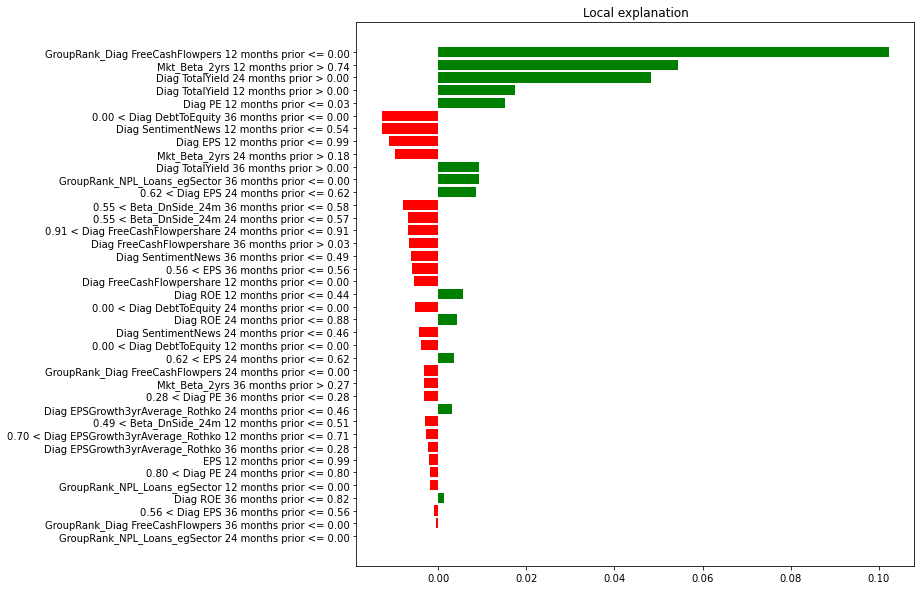

In [11]:
# create the lime explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, # training data must be a numpy array
    feature_names=X_train.columns, 
    mode='regression'
)

# print y_hat and the true value of the 100th test example
y_hat = rf.predict([X_test.values[100]])[0]
print("prediction: ", y_hat)
print("True value: ", y_test.iloc[100])


# explain the 10th test example.
exp = explainer.explain_instance(X_test.values[100],rf.predict, num_features=100)

fig = exp.as_pyplot_figure()
fig.set_size_inches(10, 10)

In the cell above at the top we have printed the true and predicted value of the 100-th sample in the test set. Notice that the prediction was lower than the true value. Let us run over how to explain the plot above:

1. On the left are the features in our data. From top to bottom the features are ordered from most important to least important.
2. Green bars mean that the feature is positively correlated with the average return, and red bars mean that features is negatively correlated with average return.
3. ```Diag TotalYield 24 months prior > 0.00``` this feature has green bar meaning that values greater than 0.00 are positively correlated with the average return.
4. ```Mkt_Beta_2yrs 24 months prior > 0.18``` this feature has a red bar meaning that values greater than 0.18 are negatively correlated with the average return.
5. ```Group_Rank_Diag FreeCashFlowpers 12 months prior <= 0.00``` recall from our preprocessing that we scaled this feature to between 0 and 1. It looks as though lime has been perturbing the input to be negative for this feature. This is not really what we want but it highlights a limitation of lime.

Lets use lime to explain another test example.

prediction:  0.11663791445041698
True value:  0.3176796557260271


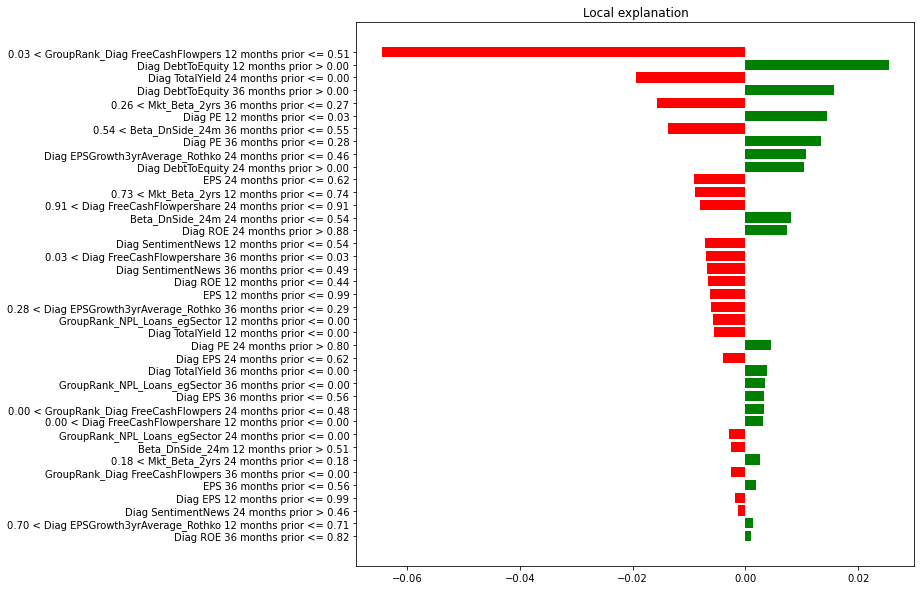

In [12]:
# print y_hat and the true value of the 15th test example
y_hat = rf.predict([X_test.values[15]])[0]
print("prediction: ", y_hat)
print("True value: ", y_test.iloc[15])

# explain the 10th test example.
exp = explainer.explain_instance(X_test.values[15],rf.predict, num_features=100)

fig = exp.as_pyplot_figure()
fig.set_size_inches(10, 10)

## Shap

The second package we will look at is called Shap. This package takes a more game theoretic approach to explaining a model. One of the main advantages that Shap has over Lime is that it attempts to explain the model throughout the global feature space as opposed to locally around one sample (although shap can also be used to explain individual samples). The main disadvantage of Shap however is that it can take an age to run. The runtime of Shap is dependent on the complexity of model so we will run it on a much simpler random forest.  

In [13]:
from sklearn.ensemble import RandomForestRegressor

# limit the random forest to 20 decision trees with a maximum depth of 10
rf = RandomForestRegressor(criterion = 'mse', n_estimators = 20, max_depth=10)
rf.fit(X_train, y_train)
mse = mean_squared_error(y_test, rf.predict(X_test))
print("Test error: ", mse)

Test error:  0.0939180344908243


Now let take a quick look at the feature importances for this new model before we use Shap.

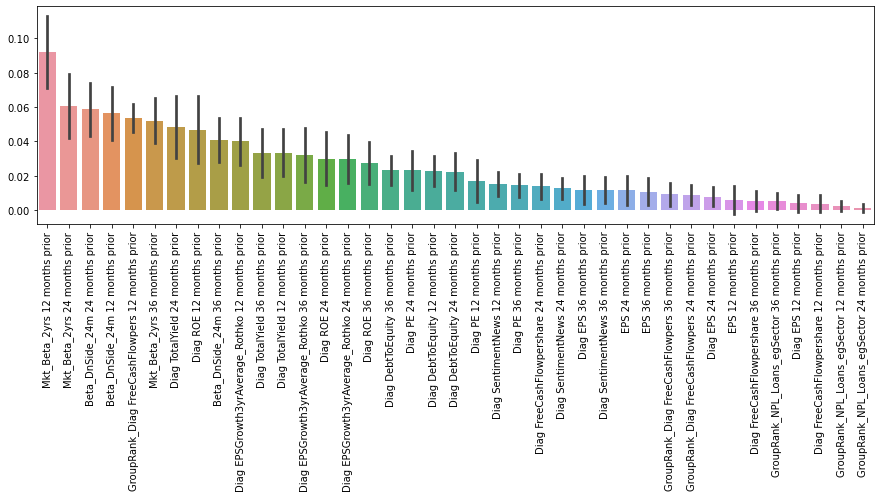

In [14]:
trees = rf.estimators_
feature_importances = pd.DataFrame(index = X.columns)

for i in range(len(trees)):
    col_name = "tree_" + str(i)
    feature_importances[col_name] = trees[i].feature_importances_

# now we find the mean feature importance for each feature
tree_names = feature_importances.columns
feature_importances['mean_feature_importance'] = feature_importances[tree_names].mean(axis=1)
feature_importances = feature_importances.sort_values(by=['mean_feature_importance'], ascending=False)
feature_importances = feature_importances.drop('mean_feature_importance', axis=1)

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.barplot(
    data=feature_importances.T, 
    ax=ax,
    ci="sd" # include standard deviation error bars
)
# rotate the x-axis labels by 90 degrees
ax.set_xticklabels(rotation=90, labels=feature_importances.index);

Now let us run Shap.

In [15]:
"""
This cell takes a long time to run.
"""
import shap

# create an explainer for the random forest model
explainer = shap.TreeExplainer(rf)

# calculate the shap values for X_test
shap_values = explainer.shap_values(X_test)

Now let us plot a summary plot. 

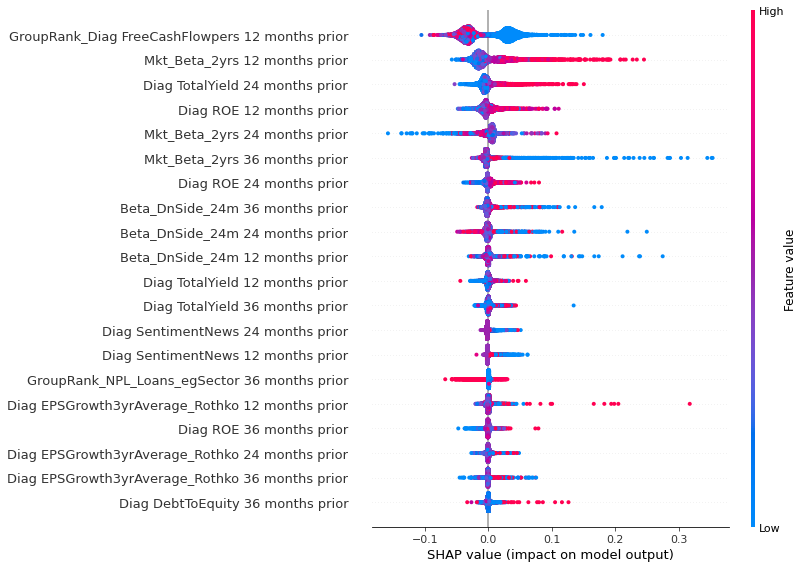

In [16]:
shap.summary_plot(shap_values, X_test)

The summary plots can be interpreted as follows:

1. On the left are the features in our data. From top to bottom the features are ordered from most important to least important.
2. Notice that the plot is made up of lots of dots. Each dot represents a sample in ```X_test```. Red dots mean that the sample had a high value for that feature and blue dots mean that sample had a low value for that feature. 
3. Along the x-axis was have the SHAP value. If a sample has a positive shap value for a feature, that means that feauture is assosciated with a higher average return. If a sample has a negative SHAP value for a feature, that means that feature is assosciated with a lower predicition. Look at ```Diag TotalYield 24 months prior```. The samples coloured red tend to have a positive shap value. This means that a high ```Diag TotalYield 24 months prior``` is assosciated with a positive SHAP value and therefore a higher average return.

Now let us take a look at decision plots. To avoid the decision plot being too cluttered we just use the first 15 test. 

Expected value of the model: [0.05443232]


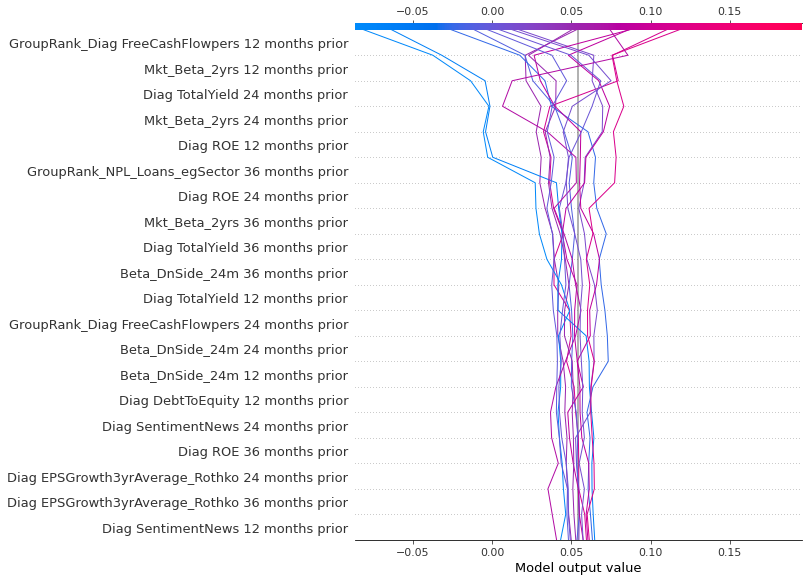

In [17]:
features = X_test.iloc[:15]
expected_value = explainer.expected_value
shap_values = explainer.shap_values(features)
print("Expected value of the model:", expected_value)
shap.decision_plot(expected_value, shap_values, features)

Descion plots can be interpreted as follows:

1. The x-axis shows the output of the model. At the top of the plot where the lines intersect the color bar correspond to the output of the model for that sample. 
2. The features on the left are ordered from most important at the top to least important at the bottom. 
3. The lines converge at the bottom to the expected output of the model. 
4. From bottom to top we can see how each feature affects the output of the model with respect to the expected value of the model.

The [shap documentation](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html) has a more in-depth description of how to interpret decision plots. 

# Multi-task models

At the moment we have only been using our models to predict the average return of a company. This means that if we were to use our models to select stocks then we would only be selecting stocks that were predicted to have a good average return. In this section, we will look at creating a multi-task learner. That is we will create another random forest model to predict the return on equity (ROE) of a company and use both random forests to select stocks that have a good predicted ROE and a good predicted average returns.

First we need to create a dataset that we can use to train the random forest model to predict the ROE of a company. We will use the december ROE as the independent variable for our model, and use all the same dependent variables as before apart from the variables relating to ROE.

In [18]:
def getRoe(row):
    """
    for a row in X.csv, get the correct Decemeber ROE.
    """
    year = row['YEAR']
    ticker = row['TICKER']
    date = str(year) + "-12-31"
    value = roe[roe["TICKER"] == ticker][date].values[0]
    row['AVERAGE RETURN'] = value
    
    if row.name % 1000 == 0:
        print(row.name, end='\r')
    return row

In [19]:
X = pd.read_csv("X.csv")
roe = pd.read_csv("Data/Diag ROE.csv")

# drop the years we are not interested in
for col in roe.columns[4:]:
    year = col[:4]
    if year not in ['2004', '2007', '2010', '2013', '2016', '2019']:
        roe.drop(col, inplace=True, axis=1)
        
X = X.apply(getRoe, axis=1)
X = X.rename(columns={"AVERAGE RETURN" : "END ROE"})
X.head()

,NAME,TICKER,SECTOR,COUNTRY,YEAR,END ROE,Beta_DnSide_24m 12 months prior,Beta_DnSide_24m 24 months prior,Beta_DnSide_24m 36 months prior,Diag DebtToEquity 12 months prior,...,EPS 36 months prior,GroupRank_Diag FreeCashFlowpers 12 months prior,GroupRank_Diag FreeCashFlowpers 24 months prior,GroupRank_Diag FreeCashFlowpers 36 months prior,GroupRank_NPL_Loans_egSector 12 months prior,GroupRank_NPL_Loans_egSector 24 months prior,GroupRank_NPL_Loans_egSector 36 months prior,Mkt_Beta_2yrs 12 months prior,Mkt_Beta_2yrs 24 months prior,Mkt_Beta_2yrs 36 months prior
0,Antofagasta plc,8,Materials,United Kingdom,2019,6.601105,0.466629,0.613881,0.605679,0.000323,...,0.563397,0.716,0.473,0.115,0.0,0.0,0.0,0.733146,0.179791,0.266553
1,Ashtead Group plc,11,Industrials,United Kingdom,2019,29.917032,0.520017,0.599024,0.582105,0.000942,...,0.563424,0.603,0.521,0.105,0.0,0.0,0.0,0.749883,0.180655,0.265154
2,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,2019,15.657565,0.449442,0.504130,0.479913,0.000225,...,0.563414,0.413,0.386,0.547,0.0,0.0,0.0,0.728778,0.180987,0.258411
3,Bellway p.l.c.,17,Consumer Discretionary,United Kingdom,2019,19.661448,0.460925,0.492347,0.491910,0.000125,...,0.563498,0.000,0.000,0.000,0.0,0.0,0.0,0.728606,0.181924,0.260856
4,Balfour Beatty plc,18,Industrials,United Kingdom,2019,11.931065,0.447137,0.538631,0.540481,0.000915,...,0.563386,0.000,0.000,0.000,0.0,0.0,0.0,0.724920,0.179470,0.257796


Now lets clip the outliers. Again we do not scale the independent variable.

In [20]:
years = list(set(X['YEAR']))

for year in years:      
    X_year = X.loc[X['YEAR'] == year, 'END ROE']
    upperlim = X_year.quantile(0.95)
    lowerlim = X_year.quantile(0.05)
    X_year.clip(lower=lowerlim, upper=upperlim, inplace=True)
    X.loc[X['YEAR'] == year, 'END ROE'] = X_year

Now we split the data into a training and a test set using the same random state as before.

In [21]:
y = X['END ROE']
X = X.drop([
    'END ROE',
    'NAME',
    'TICKER',
    'SECTOR',
    'COUNTRY',
    'YEAR'
], axis=1)

X_train_roe, X_test_roe, y_train_roe, y_test_roe = train_test_split(X, y, test_size=0.33, random_state=30)

Let us plot a histogram of ```y``` to see if ```END ROE``` is normally distributed.

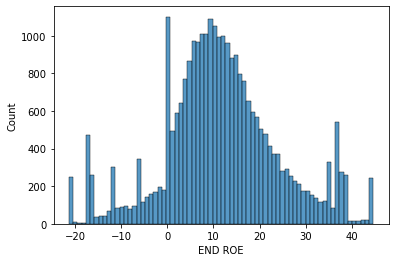

In [22]:
sns.histplot(y);

The ```END ROE``` does not look to be normally distributed. However, since we we are using the model trained to predict ```END ROE``` in conjunction with model the average return this is not as big of an issue. 

Now let us train two new random forest to predict ```END ROE``` and ```AVERAGE RETURN```. We will create a simple class that will allow us to train, test, and use the multiclass learner to predict the best stocks. 

In [23]:
from sklearn.ensemble import RandomForestRegressor

class MultiTaskRandomForest:
    def __init__(self, n_estimators=(50,50), max_depth=(15,15)):
        self.rf_ret = RandomForestRegressor(
            n_estimators = n_estimators[0],
            max_depth = max_depth[0],
            criterion = 'mse'
        )
        
        self.rf_roe = RandomForestRegressor(
            n_estimators = n_estimators[1],
            max_depth = max_depth[1],
            criterion = 'mse'
        )
        
    def fit(self, X_train, y_train_ret, y_train_roe):
        self.rf_ret.fit(X_train, y_train_ret)
        self.rf_roe.fit(X_train, y_train_roe)
        
    def predict(self, X):
        y_hat = (
            self.rf_ret.predict(X),
            self.rf_roe.predict(X)
        )
        return y_hat
        
    def getBestStocks(self, X, q=0.8):
        """
        Select the best stocks in X according to the predidictions of the random forests.
        Stocks are select if their prediction y_hat is greater than the q-th quantile of the
        predictions. This function returns three boolean arrays (True if the stock has
        been selected, and False if it has not). The first array is the union of the stocks
        selected by both random forests. The second array contains the stocks selected by the 
        random forest trained to predict average returns. The third array contains stocks selected
        by the random forest trained to predice ROE.
        """
        y_hat_ret, y_hat_roe = self.predict(X)
        
        lowerlim_ret = pd.Series(y_hat_ret).quantile(q=q)
        lowerlim_roe = pd.Series(y_hat_roe).quantile(q=q)
        
        best_stocks_ret = y_hat_ret > lowerlim_ret # best stocks in terms of predicted average return
        best_stocks_roe = y_hat_roe > lowerlim_roe # best stocks in terms of predicted roe
        best_stocks = best_stocks_ret & best_stocks_roe # union of best_stocks_roe and best_stocks_ret
        
        return best_stocks, best_stocks_ret, best_stocks_roe

Let us train a multi-task random forest.

In [24]:
multi_task_rf = MultiTaskRandomForest()
multi_task_rf.fit(X_train, y_train, y_train_roe)

Let us see how well these stocks actually performed.

In [25]:
best_stocks, best_stocks_ret, best_stocks_roe = multi_task_rf.getBestStocks(X_test)
print(y_test.loc[best_stocks_ret].mean())
print(y_test.loc[best_stocks_roe].mean())
print(y_test.loc[best_stocks].mean())

0.1537027721779251
0.07121271666914739
0.16641936083085548


We can see above that the intersection of stocks selected by the average return and ROE random forests perform better than the stocks selected by each random forest individually. Finally let us look at how many stocks the random forests selected.

In [26]:
print(sum(best_stocks))
print(sum(best_stocks_ret))
print(sum(best_stocks_roe))

545
1849
1849


## Out of sample 2020 predictions

Now, let us use the multi-task random forest to predict the average returns in 2020. First we have to prepare the data. Let us start by preparing the average returns.

In [27]:
# load the return and index data
df = pd.read_csv("Data/TotalReturn_BaseCCY.csv")
index = pd.read_csv("Index/INDEX.csv", skiprows=8)

# keep only the 2020 data
df = df[df.columns[:13]]
index = index[index.columns[4:13]]
index.columns = df.columns[4:]

# adjust the 2020 using the indexes
df[df.columns[4:]] += 1
df[df.columns[4:]] = df[df.columns[4:]].divide(1 + index.iloc[0], axis=1)
df[df.columns[4:]] -= 1

# drop any rows that contain a missing value
df = df.dropna()

# clip the returns to remove outliers
upperlim = df[df.columns[4:]].quantile(0.95)
lowerlim = df[df.columns[4:]].quantile(0.05)
df[df.columns[4:]] = df[df.columns[4:]].clip(lower=lowerlim, upper=upperlim, axis=1)

# calculate the geometric mean
df["AVERAGE RETURN"] = (df[df.columns[4:]] + 1).product(axis=1) - 1
df = df.drop(upperlim.index, axis=1)
df.head()

,NAME,TICKER,SECTOR,COUNTRY,AVERAGE RETURN
7,Antofagasta plc,8,Materials,United Kingdom,0.173110
10,Ashtead Group plc,11,Industrials,United Kingdom,0.208256
15,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,-0.348825
16,Bellway p.l.c.,17,Consumer Discretionary,United Kingdom,-0.377606
17,Balfour Beatty plc,18,Industrials,United Kingdom,-0.126351


Now that we have the average returns for 2020, we need to extract the dependent variables for 2020.

In [28]:
files = os.listdir('Data')
files.remove("TotalReturn_BaseCCY.csv")
[files.remove(file) for file in ['EBITDA_SALES.csv', 'OperationalLev_USD.csv', 'Rev_Quality.csv', 'NI_Sales.csv']]

for file in files:
    path = "Data/" + file
    x = pd.read_csv(path)
    x = x[["2019-12-31", "2018-12-31", "2017-12-31"]]
    names = [
        file[:-4] + " 12 months prior",
        file[:-4] + " 24 months prior",
        file[:-4] + " 36 months prior"
    ]
    x.columns = names
    x = x.loc[x.index.isin(df.index)]
    df = df.merge(x, left_index=True, right_index=True, how='left')
df.head()

,NAME,TICKER,SECTOR,COUNTRY,AVERAGE RETURN,Beta_DnSide_24m 12 months prior,Beta_DnSide_24m 24 months prior,Beta_DnSide_24m 36 months prior,Diag DebtToEquity 12 months prior,Diag DebtToEquity 24 months prior,...,EPS 36 months prior,GroupRank_Diag FreeCashFlowpers 12 months prior,GroupRank_Diag FreeCashFlowpers 24 months prior,GroupRank_Diag FreeCashFlowpers 36 months prior,GroupRank_NPL_Loans_egSector 12 months prior,GroupRank_NPL_Loans_egSector 24 months prior,GroupRank_NPL_Loans_egSector 36 months prior,Mkt_Beta_2yrs 12 months prior,Mkt_Beta_2yrs 24 months prior,Mkt_Beta_2yrs 36 months prior
7,Antofagasta plc,8,Materials,United Kingdom,0.173110,0.157351,-0.082644,3.429410,33.900860,37.012188,...,0.108119,0.362,0.716,0.473,0.0,0.0,0.0,1.392552,0.939960,1.264044
10,Ashtead Group plc,11,Industrials,United Kingdom,0.208256,1.711203,1.407220,2.750894,134.179611,108.081047,...,1.300219,0.645,0.603,0.521,0.0,0.0,0.0,2.095626,1.654422,1.401318
15,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,-0.348825,-0.180225,-0.562285,-1.582904,23.872400,25.876867,...,0.796256,0.265,0.413,0.386,0.0,0.0,0.0,1.122903,0.753498,1.454174
16,Bellway p.l.c.,17,Consumer Discretionary,United Kingdom,-0.377606,0.133461,-0.241832,-2.121066,10.711926,14.288648,...,4.885805,0.000,0.000,0.000,0.0,0.0,0.0,1.159806,0.746176,1.603066
17,Balfour Beatty plc,18,Industrials,United Kingdom,-0.126351,-0.606063,-0.626621,-0.007258,60.923332,105.029587,...,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.889224,0.588832,1.212978


Now we clip the data to remove outliers.

In [29]:
upperlim = df[df.columns[5:]].quantile(0.95)
lowerlim = df[df.columns[5:]].quantile(0.05)
df[df.columns[5:]] = df[df.columns[5:]].clip(lower=lowerlim, upper=upperlim, axis=1)

We scale the dependent variables to be between 0 and 1

In [30]:
from sklearn.preprocessing import MinMaxScaler

x = df[df.columns[5:]].values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df[df.columns[5:]] = x_scaled

We impute the missing values use k-nearest neighbours.

In [31]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50) # 50 neighbours was the best we found in the preprocessing notebook
df[df.columns[5:]] = imputer.fit_transform(df[df.columns[5:]])

Finally we split the dependent and independent variables.

In [32]:
X_2020 = df.drop([
    'NAME',
    'TICKER',
    'SECTOR',
    'COUNTRY',
    'AVERAGE RETURN'
], axis=1)

y_2020 = df['AVERAGE RETURN']

Let us use the multi-task random forest selelect the best stocks in 2020.

In [33]:
best_stocks_2020, best_stocks_ret_2020, best_stocks_roe_2020 = multi_task_rf.getBestStocks(X_2020)
print(y_2020.loc[best_stocks_ret_2020].mean())
print(y_2020.loc[best_stocks_roe_2020].mean())
print(y_2020.loc[best_stocks_2020].mean())

-0.03331699966091516
-0.015269396574977319
0.019492738918833068


The random forests on their own were not able to select stocks that made money but together they were able to pick stocks that made money. Below is the mean average return in 2020 which is negative so the performance of our multi-task learner okay.

In [34]:
y_2020.mean()

-0.04687470471792529